In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
income = pd.read_csv('adult_income.csv')

In [3]:
income.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
income.columns = income.columns.str.replace('.','_')

In [5]:
income['income_map'] = income.income.map({'<=50K':0, '>50K': 1})
income['sex_map'] = income.sex.map({'Female':0, 'Male':1})
income['race_map']=income.race.map({'White':0, 'Black':1, 
                                    'Asian-Pac-Islander':2, 'Amer-Indian-Eskimo':3})
income['marital_map'] = income.marital_status.map({'Widowed':0, 'Divorced':1, 'Separated':2,
                                                  'Never-married':3, 'Married-civ-spouse':4,
                                                  'Married-spouse-absent':5, 'Married-AF-spouse':6})
income['rel_map']=income.relationship.map({'Not-in-family':0, 'Unmarried':0, 
                                           'Own-child':0, 'Other-relative':0, 
                                           'Husband':1, 'Wife':1})
income['work_map']=income.workclass.map({'?':0, 'Private':1, 'State-gov':2, 'Federal-gov':3, 
                                        'Self-emp-not-inc':4, 'Self-emp-inc': 5, 'Local-gov': 6,
                                        'Without-pay':7, 'Never-worked':8})

In [6]:
num_cols = ['age', 'sex_map', 'race_map','education_num', 'work_map', 
            'marital_map', 'rel_map', 'hours_per_week','capital_gain', 'capital_loss', 
            'fnlwgt', 'income_map']

In [7]:
income=income[num_cols].fillna(-9999)

In [8]:
income.head()

,age,sex_map,race_map,education_num,work_map,marital_map,rel_map,hours_per_week,capital_gain,capital_loss,fnlwgt,income_map
0,90,0,0.0,9,0,0,0,40,0,4356,77053,0
1,82,0,0.0,9,1,0,0,18,0,4356,132870,0
2,66,0,1.0,10,0,0,0,40,0,4356,186061,0
3,54,0,0.0,4,1,1,0,40,0,3900,140359,0
4,41,0,0.0,10,1,2,0,40,0,3900,264663,0


In [9]:
features=['age', 'sex_map', 'race_map','education_num', 'work_map', 
          'marital_map', 'rel_map', 'hours_per_week','capital_gain', 
          'capital_loss', 'fnlwgt']

target=['income_map']

In [10]:
X = income[features].values
y = income[target].values.flatten()

In [11]:
from sklearn.model_selection import train_test_split
    
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

# Logistic Regression

In [12]:
def logistic_regression():
    
    # Instantiates and trains a logistic regression model using grid search  
    # to find optimalhyperparameter values 
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV
    
    logreg = LogisticRegression()
    grid_values = {'penalty' : ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}
    
    grid_lr_rec = GridSearchCV(logreg, param_grid = grid_values, scoring = 'accuracy')
    grid_lr_rec.fit(X, y)
    
    return grid_lr_rec.best_estimator_

In [13]:
logreg = logistic_regression()

In [14]:
def evaluation(model):
    from sklearn.metrics import classification_report
    
    # This function gives provides verious evaluation metrics for the input model
    
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred, target_names = ['Under 50k', 'Over 50k']))
    print('Training Set Accuracy Score: {:.2f}'.format(model.score(X_train, y_train)))
    print('Testing Set Accuracy Score: {:.2f}'.format(model.score(X_test, y_test)))

In [15]:
evaluation(logreg)

             precision    recall  f1-score   support

  Under 50k       0.87      0.93      0.90      6193
   Over 50k       0.72      0.54      0.62      1948

avg / total       0.83      0.84      0.83      8141

Training Set Accuracy Score: 0.84
Testing Set Accuracy Score: 0.84


In [16]:
def dummy():
    
    # Creates a dummy classifier to always predict the more frequent class, 
    # in order to give us an idea about the existing class inbalance in our dataset.
    
    from sklearn.dummy import DummyClassifier
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    dummy_clf = DummyClassifier(strategy = 'most_frequent').fit(X,y)
    
    print('Dummy Classifier Accuracy Score: {:.2f}'.format(dummy_clf.score(X_test, y_test)))

dummy()

Dummy Classifier Accuracy Score: 0.76


###### Although this model initially appears to preform somewhat well with an accuracy of 84% we see that by breaking down our evaluation metrics and comparing with a dummy classifier this model falls short. 

Due to a class imbalance in our dataset of approximately 75%/25% simply by predicting the most frequent class the dummy classifier can achieve an accuracy score of 76%. The logistic regression model accuracy of 84% only marginally outpreforms this null baseline.

In [17]:
def confusion(model):
    
    # Creats a confusion matrix/heatmap for the logistic regression models predicted values
    from sklearn.metrics import confusion_matrix
    
    y_pred = model.predict(X_test)
    confusion_mc = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(confusion_mc)

    plt.figure(figsize=(5.5,4))
    sns.heatmap(df_cm, annot=True)
    plt.title('Model Accuracy:{:.3f}'.format(model.score(X_test, y_test)))

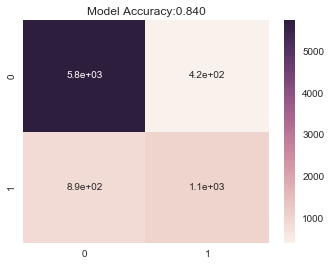

In [18]:
confusion(logreg)

In [19]:
def precision_recall(model):
    from sklearn.metrics import precision_recall_curve
    
    proba = model.predict_proba(X_test)
    
    precision, recall, threshold = precision_recall_curve(y_test, proba[:,1])
    
    plt.plot(precision, recall)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall Curve')

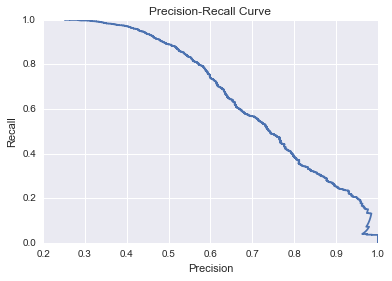

In [20]:
precision_recall(logreg)

In [21]:
def roc_curve(model):
    from sklearn.metrics import roc_curve, auc
    
    #scores = model.decision_function(X_test)
    proba = model.predict_proba(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, proba[:,1])
    
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve. AUC: {}'.format(auc(fpr, tpr)))

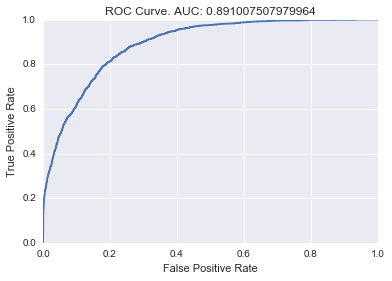

In [22]:
roc_curve(logreg)

The Precision-Recall curve shows the trade off between precision and recall scores as we vary the decision threshold for classification (using either using either a probability threshold or a decision function threshold). Likewise, the ROC curve (Receiver Operating Charastic) preforms the same feat for the True Positive Rate (recall) and the False Positive Rate. 

In [23]:
from sklearn.metrics import precision_score

y_pred = logreg.predict(X_test)

micro_avg = precision_score(y_test, y_pred, average='micro')
macro_avg = precision_score(y_test, y_pred, average='macro')

print('Micro Average Precision Score: {:.2f}'.format(
    precision_score(y_test, y_pred, average='micro')))
print('Macro Average Precision Score: {:.2f}'.format(
    precision_score(y_test, y_pred, average='macro')))


Micro Average Precision Score: 0.84
Macro Average Precision Score: 0.79


When the micro average (each instance has same weight) preforms better than the macro average (each class has same weight) this is an indicator that the model is preforming better on the more frequent class. This holds true with the results from the evaluation function above, in which the model performed substantially better on the class earning less than $50,000.

In [24]:
print('Number of instances in the > $50,000 class: {}'.format(
    len(income[income.income_map ==1])))
print('Number of instances in the < $50,000 class: {}'.format(
    len(income[income.income_map ==0])))

Number of instances in the > $50,000 class: 7841
Number of instances in the < $50,000 class: 24720


# Decision Tree Classifier

In [25]:
def decision_tree():
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import GridSearchCV
    
    grid_values = {'max_depth':np.arange(1,10), 'min_samples_leaf': np.arange(1,50,10)}
    clf = DecisionTreeClassifier()
    
    grid_dec_tree = GridSearchCV(clf, param_grid = grid_values)
    grid_dec_tree.fit(X, y)
    
    return grid_dec_tree.best_estimator_

In [26]:
clf_dec_tree = decision_tree()

In [27]:
 evaluation(clf_dec_tree)

             precision    recall  f1-score   support

  Under 50k       0.86      0.95      0.91      6193
   Over 50k       0.78      0.52      0.63      1948

avg / total       0.84      0.85      0.84      8141

Training Set Accuracy Score: 0.85
Testing Set Accuracy Score: 0.85


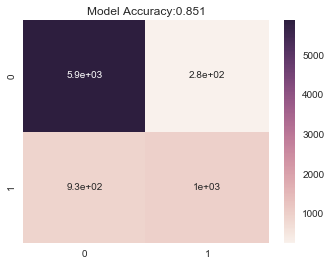

In [28]:
confusion(clf_dec_tree)

# Random Forest Classifier

In [29]:
def random_forest():
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    
    clf = RandomForestClassifier(random_state=0)
    grid_values = {'max_depth': np.arange(1,11,2), 'max_features': np.arange(1,11,2)}
    
    grid_clf = GridSearchCV(clf, param_grid = grid_values)
    grid_clf.fit(X, y)
    
    
    return grid_clf.best_estimator_

In [30]:
rdm_forest_clf = random_forest()

In [31]:
evaluation(rdm_forest_clf)

             precision    recall  f1-score   support

  Under 50k       0.87      0.96      0.91      6193
   Over 50k       0.81      0.55      0.65      1948

avg / total       0.86      0.86      0.85      8141

Training Set Accuracy Score: 0.87
Testing Set Accuracy Score: 0.86


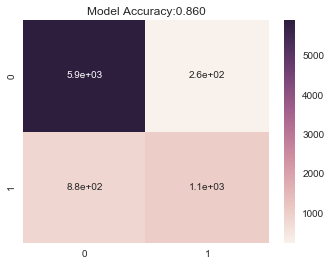

In [32]:
confusion(rdm_forest_clf)

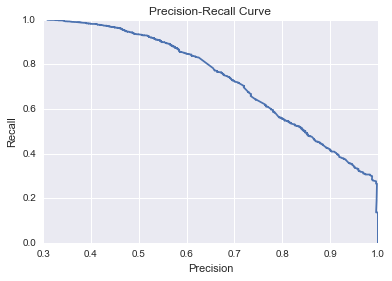

In [33]:
precision_recall(rdm_forest_clf)

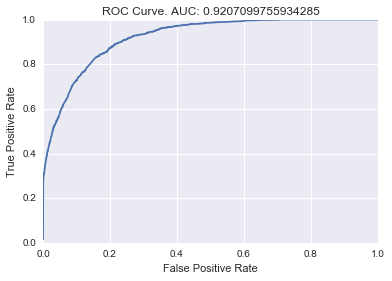

In [34]:
roc_curve(rdm_forest_clf)

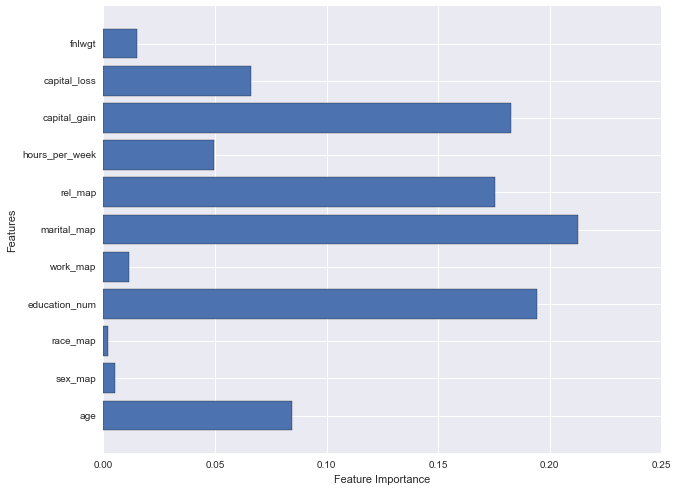

In [35]:
def plot_features(tree):

    feats = tree.feature_importances_

    plt.figure(figsize = (10,8))
    pos = np.arange(len(features))+1
    plt.barh(pos, feats, align='center')
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.yticks(pos, (features));
    
plot_features(rdm_forest_clf)

# Gradient Boosted Decision Trees

In [36]:
def gbdc():
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import GridSearchCV
    
    grid_values = {'learning_rate': np.arange(0.01, 1.1, 0.25), 'max_depth': np.arange(2,6,1)}
    
    clf = GradientBoostingClassifier()
    
    grid_gbdc = GridSearchCV(clf, param_grid = grid_values)
    grid_gbdc.fit(X_train, y_train)
    
    grid_gbdc.best_estimator_.score(X_train, y_train)
    
    print('Best Parameters: {}'.format(grid_gbdc.best_params_))
    print('Train Score: {:.2f}'.format(grid_gbdc.best_estimator_.score(X_train, y_train)))
    print('Test Score: {:.2f}'.format(grid_gbdc.best_estimator_.score(X_test, y_test)))
    
gbdc()

Best Parameters: {'learning_rate': 0.26000000000000001, 'max_depth': 3}
Train Score: 0.88
Test Score: 0.86
